In [2362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from scipy.signal import lfilter

In [1604]:
def remove_noise(frame, first_par, second_par):
    w_out_noise = savgol_filter(frame["StockValue"], first_par, second_par)
    frame["StockValue"] = w_out_noise
    frame_f = frame[["StockValue"]]
    # frame_f = frame_f.rename(columns={"StockValue": "StockValue_wo_noisede"})
    return frame_f

In [2340]:
def remove_noise_lFilter(frame, b, a):
    w_out_noise_lFilter = lfilter(b, a, frame["StockValue"])
    frame["StockValue"] = w_out_noise_lFilter
    frame_f = frame[["StockValue"]]
    # frame_f = frame_f.rename(columns={"StockValue": "StockValue_wo_noisede"})
    return frame_f

In [5]:
def ma_columns(frame_column, list_ma):
    MAs = [] 
    for ma in list_ma:
        MA = pd.DataFrame(sm.short_moving_average(frame_column, ma)["StockValue"]).rename(columns={"StockValue": f"MA_{ma}"})
        MAs.append(MA)
        
    frame = MAs[0].join(MAs[1])
    for i in range(len(MAs)-2):
        frame = frame.join(MAs[i+2])
    
    frame = frame.dropna()
    
    return frame

In [2361]:
def buy_sell_recommendations(new_frame):
    ### ma_50_200 farkı sıfırdan büyük veya 5 günlük trajectory değeri sıfırdan büyükse;
    #### MA_7_50 farkı sıfıra eşit veya büyükse devamını uygula
    #### MA_7_50 farkı sıfırdan küçükse devamını uygula
    new_frame['rec_1'] = np.where((((new_frame["MA_50_200"]>0) | (new_frame["MA_50_200_CH"]>0)))
                                  # & (new_frame["StockValue"] > new_frame["StockValue_WoN"] * 0.90))
                                  & (((new_frame['MA_7_50']>=0) & (new_frame['MA_7_50']*1 > new_frame["MA_50_200"]*0.8))
                                    | ((new_frame['MA_7_50']<0) & (new_frame['MA_7_50']*1 > new_frame["MA_50_200"]*1))
                                    )
                                         ,"BUY", "SELL")
    
    new_frame['rec_2'] = np.where((((new_frame["MA_50_200"]>-0.01) | (new_frame["MA_50_200_CH"]>0)))
                                  # & (new_frame["StockValue"] > new_frame["StockValue_WoN"] * 0.90))
                                  & (((new_frame['MA_14_100']>=0) & (new_frame['MA_14_100']*1 > new_frame["MA_50_200"]*0.8))
                                    | ((new_frame['MA_14_100']<0) & (new_frame['MA_14_100']*1 > new_frame["MA_50_200"]*1))
                                    )
                                     ,"BUY", "SELL")
    
    return new_frame

In [7]:
def get_locations(new_frame):
    loc_first=[]
    for row in range(new_frame.shape[0]-1):

            if new_frame.iloc[row,:].rec_1 == "SELL":
                if new_frame.iloc[row+1,:].rec_1 == "BUY":
                    start = row+1
                    loc_first.append(start)

            if new_frame.iloc[row,:].rec_1 == "BUY":
                if new_frame.iloc[row+1,:].rec_1 == "SELL":
                    end = row+2
                    loc_first.append(end)
                    
    loc_second=[]
    for row in range(new_frame.shape[0]-1):

        if new_frame.iloc[row,:].rec_2 == "SELL":
            if new_frame.iloc[row+1,:].rec_2 == "BUY":
                start = row+1
                loc_second.append(start)

        if new_frame.iloc[row,:].rec_2 == "BUY":
            if new_frame.iloc[row+1,:].rec_2 == "SELL":
                end = row+2
                loc_second.append(end)
                
    return [loc_first, loc_second]

In [8]:
def get_transactions(new_frame, column, locations):
    if new_frame.iloc[0,:][str(column)] == "SELL":
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(0,len(locations),2), range(1,len(locations),2))]
    else:
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(1,len(locations),2), range(2,len(locations),2))]
        transactions.insert(0, [0, locations[0]])

    return transactions

In [9]:
def returns(new_frame, list_of_transactions):
    returns = []
    for transactions in list_of_transactions:
        buy = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[0]
        sell = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[-1]
        ret = (sell-buy)/buy
        returns.append(ret)
    
    return returns

In [10]:
def prod(list_of_all_returns):
    return np.prod([ret+1 for ret in list_of_all_returns]) 

In [11]:
def get_only_frame(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [1782]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%d-%m-%Y")

In [1783]:
def convert_str_from_date(date: str):
    return datetime.datetime.strftime(date, "%d-%m-%Y")

In [1784]:
def increment_date(date:str, increment_day:int):
    date = convert_date(date)
    date = date + datetime.timedelta(days=increment_day)
    date = convert_str_from_date(date)
    
    return date

In [162]:
increment_date("01-01-2015", 2)

'03-01-2015'

In [16]:
def simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    loc_first = get_locations(new_frame)[0]
    loc_second = get_locations(new_frame)[1]
    
    first_transactions = get_transactions(new_frame, "rec_1", loc_first)
    second_transactions = get_transactions(new_frame, "rec_2", loc_second)

    first_returns = returns(new_frame, first_transactions)
    second_returns = returns(new_frame, second_transactions)
    
    first_cum_return = prod(first_returns)
    print(f"Final position of first transactions : {first_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in first_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of first transactions        : {[round(first,3) for first in first_returns]}")
    print(f"Locations of first transactions      : {first_transactions}")
    print("-"*85)
    
    second_cum_return  = prod(second_returns)
    print(f"Final position of second transactions: {second_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in second_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of second transactions       : {[round(second,3) for second in second_returns]}")
    print(f"Locations of second transactions     : {second_transactions}")
    print("-"*85)

    totalReturn = (first_cum_return + second_cum_return) / 2
    print(f"Ultimate position : {totalReturn}")
    
    return totalReturn

---

---

In [2626]:
def get_only_frame_simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = pd.read_pickle(stock_name)
    start_date = convert_date(start_date)
    end_date = convert_date(end_date)
    frame = frame[(frame.HGDG_TARIH < end_date) & (frame.HGDG_TARIH > start_date)]
    date = frame[["HGDG_TARIH"]]
    
    new_frame = remove_noise(frame, noise_first_par, noise_second_par)           # SAVGOL FILTER
    # new_frame = remove_noise_lFilter(frame, noise_first_par, noise_second_par)     # LFILTER
    
    #scaling
    ## scaling
    new_frame.iloc[-100:,:]["StockValue"] = scale(new_frame.iloc[-100:,:]["StockValue"])
    ## min_max scaling
    # new_frame = new_frame.iloc[-50:,:]
    # scaler = MinMaxScaler()
    # new_frame[["StockValue"]] = scaler.fit_transform(new_frame[["StockValue"]])
    
    # new_frame = ma_columns(frame_f, ma_list)
    
    # new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    # new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    # new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    # frame = pd.read_pickle(stock_name)
    # new_frame = new_frame[["HGDG_TARIH", "StockValue"]]
    # new_frame = new_frame.join(frame)
    
    # new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.join(date)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [2627]:
def extract_and_store(stock_name, start_date, end_date):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)

In [2662]:
stock_name = "PGSUS"
ma_list=[7,14,50,100,200]
noise_first_par = 51
noise_second_par = 2

# n = 15  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# noise_first_par = b
# noise_second_par = a

general_startDate = "31-01-2000"
general_endDate = "31-12-2020"

start_date = "01-01-2011"
first_end_date = "01-02-2014"
final_last_date = "01-07-2020"

In [2663]:
observations = []
for i in range(2200):
    frame = pd.read_pickle(stock_name)
    print(first_end_date)
    if frame[frame["HGDG_TARIH"] == first_end_date].shape[0] == 1:
        frame = get_only_frame_simulation(stock_name, start_date, first_end_date, ma_list, noise_first_par, noise_second_par)
        observations.append(frame.iloc[-1,:])
    else:
        observations = observations
    first_end_date = increment_date(first_end_date, 1)

final_frame = pd.concat(observations, axis=1)
final_frame = final_frame.T
final_frame = final_frame.drop_duplicates(subset=["Date"])

new_frame = ma_columns(final_frame, ma_list)
final_frame = final_frame.join(new_frame)
final_frame = final_frame.dropna()

final_frame["MA_7_50"] = final_frame["MA_7"] - final_frame["MA_50"]
final_frame["MA_14_100"] = final_frame["MA_14"] - final_frame["MA_100"]
final_frame["MA_50_200"] = final_frame["MA_50"] - final_frame["MA_200"]

trajectory1 = sm.trajectory(final_frame[["MA_50_200"]], 20)[["MA_50_200_CH"]]
#trajectory2 = sm.trajectory(final_frame[["MA_14_100"]], 10)[["MA_14_100_CH"]]
#trajectory3 = sm.trajectory(final_frame[["MA_7_50"]], 5)[["MA_7_50_CH"]]
final_frame = final_frame.join(trajectory1)
#final_frame = final_frame.join(trajectory2)
#final_frame = final_frame.join(trajectory3)

# final_frame["MA_50_200"] = scale(final_frame["MA_50_200"]) # SCALING ZAMANA GÖRE YAP
# final_frame["MA_14_100"] = scale(final_frame["MA_14_100"])
# final_frame["MA_7_50"] = scale(final_frame["MA_7_50"])

# final_frame = buy_sell_recommendations(final_frame)
final_frame = final_frame.rename(columns={"StockValue": "StockValue_WoN"})

frame = pd.read_pickle(stock_name)
frame = frame[["StockValue"]]
final_frame = final_frame.join(frame)

final_frame = final_frame.dropna()
final_frame = buy_sell_recommendations(final_frame)

01-02-2014
02-02-2014
03-02-2014
04-02-2014
05-02-2014
06-02-2014
07-02-2014
08-02-2014
09-02-2014
10-02-2014
11-02-2014
12-02-2014
13-02-2014
14-02-2014
15-02-2014
16-02-2014
17-02-2014
18-02-2014
19-02-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

20-02-2014
21-02-2014
22-02-2014
23-02-2014
24-02-2014
25-02-2014
26-02-2014
27-02-2014
28-02-2014
01-03-2014
02-03-2014
03-03-2014
04-03-2014
05-03-2014
06-03-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

07-03-2014
08-03-2014
09-03-2014
10-03-2014
11-03-2014
12-03-2014
13-03-2014
14-03-2014
15-03-2014
16-03-2014
17-03-2014
18-03-2014
19-03-2014
20-03-2014
21-03-2014
22-03-2014
23-03-2014
24-03-2014
25-03-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

26-03-2014
27-03-2014
28-03-2014
29-03-2014
30-03-2014
31-03-2014
01-04-2014
02-04-2014
03-04-2014
04-04-2014
05-04-2014
06-04-2014
07-04-2014
08-04-2014
09-04-2014
10-04-2014
11-04-2014
12-04-2014
13-04-2014
14-04-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

15-04-2014
16-04-2014
17-04-2014
18-04-2014
19-04-2014
20-04-2014
21-04-2014
22-04-2014
23-04-2014
24-04-2014
25-04-2014
26-04-2014
27-04-2014
28-04-2014
29-04-2014
30-04-2014
01-05-2014
02-05-2014
03-05-2014
04-05-2014
05-05-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

06-05-2014
07-05-2014
08-05-2014
09-05-2014
10-05-2014
11-05-2014
12-05-2014
13-05-2014
14-05-2014
15-05-2014
16-05-2014
17-05-2014
18-05-2014
19-05-2014
20-05-2014
21-05-2014
22-05-2014
23-05-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

24-05-2014
25-05-2014
26-05-2014
27-05-2014
28-05-2014
29-05-2014
30-05-2014
31-05-2014
01-06-2014
02-06-2014
03-06-2014
04-06-2014
05-06-2014
06-06-2014
07-06-2014
08-06-2014
09-06-2014
10-06-2014
11-06-2014
12-06-2014
13-06-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

14-06-2014
15-06-2014
16-06-2014
17-06-2014
18-06-2014
19-06-2014
20-06-2014
21-06-2014
22-06-2014
23-06-2014
24-06-2014
25-06-2014
26-06-2014
27-06-2014
28-06-2014
29-06-2014
30-06-2014
01-07-2014
02-07-2014
03-07-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

04-07-2014
05-07-2014
06-07-2014
07-07-2014
08-07-2014
09-07-2014
10-07-2014
11-07-2014
12-07-2014
13-07-2014
14-07-2014
15-07-2014
16-07-2014
17-07-2014
18-07-2014
19-07-2014
20-07-2014
21-07-2014
22-07-2014
23-07-2014
24-07-2014
25-07-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

26-07-2014
27-07-2014
28-07-2014
29-07-2014
30-07-2014
31-07-2014
01-08-2014
02-08-2014
03-08-2014
04-08-2014
05-08-2014
06-08-2014
07-08-2014
08-08-2014
09-08-2014
10-08-2014
11-08-2014
12-08-2014
13-08-2014
14-08-2014
15-08-2014
16-08-2014
17-08-2014
18-08-2014
19-08-2014
20-08-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

21-08-2014
22-08-2014
23-08-2014
24-08-2014
25-08-2014
26-08-2014
27-08-2014
28-08-2014
29-08-2014
30-08-2014
31-08-2014
01-09-2014
02-09-2014
03-09-2014
04-09-2014
05-09-2014
06-09-2014
07-09-2014
08-09-2014
09-09-2014
10-09-2014
11-09-2014
12-09-2014
13-09-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

14-09-2014
15-09-2014
16-09-2014
17-09-2014
18-09-2014
19-09-2014
20-09-2014
21-09-2014
22-09-2014
23-09-2014
24-09-2014
25-09-2014
26-09-2014
27-09-2014
28-09-2014
29-09-2014
30-09-2014
01-10-2014
02-10-2014
03-10-2014
04-10-2014
05-10-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

06-10-2014
07-10-2014
08-10-2014
09-10-2014
10-10-2014
11-10-2014
12-10-2014
13-10-2014
14-10-2014
15-10-2014
16-10-2014
17-10-2014
18-10-2014
19-10-2014
20-10-2014
21-10-2014
22-10-2014
23-10-2014
24-10-2014
25-10-2014
26-10-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

27-10-2014
28-10-2014
29-10-2014
30-10-2014
31-10-2014
01-11-2014
02-11-2014
03-11-2014
04-11-2014
05-11-2014
06-11-2014
07-11-2014
08-11-2014
09-11-2014
10-11-2014
11-11-2014
12-11-2014
13-11-2014
14-11-2014
15-11-2014
16-11-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

17-11-2014
18-11-2014
19-11-2014
20-11-2014
21-11-2014
22-11-2014
23-11-2014
24-11-2014
25-11-2014
26-11-2014
27-11-2014
28-11-2014
29-11-2014
30-11-2014
01-12-2014
02-12-2014
03-12-2014
04-12-2014
05-12-2014
06-12-2014
07-12-2014
08-12-2014
09-12-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

10-12-2014
11-12-2014
12-12-2014
13-12-2014
14-12-2014
15-12-2014
16-12-2014
17-12-2014
18-12-2014
19-12-2014
20-12-2014
21-12-2014
22-12-2014
23-12-2014
24-12-2014
25-12-2014
26-12-2014
27-12-2014
28-12-2014
29-12-2014
30-12-2014
31-12-2014


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

01-01-2015
02-01-2015
03-01-2015
04-01-2015
05-01-2015
06-01-2015
07-01-2015
08-01-2015
09-01-2015
10-01-2015
11-01-2015
12-01-2015
13-01-2015
14-01-2015
15-01-2015
16-01-2015
17-01-2015
18-01-2015
19-01-2015
20-01-2015
21-01-2015
22-01-2015
23-01-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

24-01-2015
25-01-2015
26-01-2015
27-01-2015
28-01-2015
29-01-2015
30-01-2015
31-01-2015
01-02-2015
02-02-2015
03-02-2015
04-02-2015
05-02-2015
06-02-2015
07-02-2015
08-02-2015
09-02-2015
10-02-2015
11-02-2015
12-02-2015
13-02-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

14-02-2015
15-02-2015
16-02-2015
17-02-2015
18-02-2015
19-02-2015
20-02-2015
21-02-2015
22-02-2015
23-02-2015
24-02-2015
25-02-2015
26-02-2015
27-02-2015
28-02-2015
01-03-2015
02-03-2015
03-03-2015
04-03-2015
05-03-2015
06-03-2015
07-03-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

08-03-2015
09-03-2015
10-03-2015
11-03-2015
12-03-2015
13-03-2015
14-03-2015
15-03-2015
16-03-2015
17-03-2015
18-03-2015
19-03-2015
20-03-2015
21-03-2015
22-03-2015
23-03-2015
24-03-2015
25-03-2015
26-03-2015
27-03-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

28-03-2015
29-03-2015
30-03-2015
31-03-2015
01-04-2015
02-04-2015
03-04-2015
04-04-2015
05-04-2015
06-04-2015
07-04-2015
08-04-2015
09-04-2015
10-04-2015
11-04-2015
12-04-2015
13-04-2015
14-04-2015
15-04-2015
16-04-2015
17-04-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

18-04-2015
19-04-2015
20-04-2015
21-04-2015
22-04-2015
23-04-2015
24-04-2015
25-04-2015
26-04-2015
27-04-2015
28-04-2015
29-04-2015
30-04-2015
01-05-2015
02-05-2015
03-05-2015
04-05-2015
05-05-2015
06-05-2015
07-05-2015
08-05-2015
09-05-2015
10-05-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

11-05-2015
12-05-2015
13-05-2015
14-05-2015
15-05-2015
16-05-2015
17-05-2015
18-05-2015
19-05-2015
20-05-2015
21-05-2015
22-05-2015
23-05-2015
24-05-2015
25-05-2015
26-05-2015
27-05-2015
28-05-2015
29-05-2015
30-05-2015
31-05-2015
01-06-2015
02-06-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

03-06-2015
04-06-2015
05-06-2015
06-06-2015
07-06-2015
08-06-2015
09-06-2015
10-06-2015
11-06-2015
12-06-2015
13-06-2015
14-06-2015
15-06-2015
16-06-2015
17-06-2015
18-06-2015
19-06-2015
20-06-2015
21-06-2015
22-06-2015
23-06-2015
24-06-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

25-06-2015
26-06-2015
27-06-2015
28-06-2015
29-06-2015
30-06-2015
01-07-2015
02-07-2015
03-07-2015
04-07-2015
05-07-2015
06-07-2015
07-07-2015
08-07-2015
09-07-2015
10-07-2015
11-07-2015
12-07-2015
13-07-2015
14-07-2015
15-07-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

16-07-2015
17-07-2015
18-07-2015
19-07-2015
20-07-2015
21-07-2015
22-07-2015
23-07-2015
24-07-2015
25-07-2015
26-07-2015
27-07-2015
28-07-2015
29-07-2015
30-07-2015
31-07-2015
01-08-2015
02-08-2015
03-08-2015
04-08-2015
05-08-2015
06-08-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

07-08-2015
08-08-2015
09-08-2015
10-08-2015
11-08-2015
12-08-2015
13-08-2015
14-08-2015
15-08-2015
16-08-2015
17-08-2015
18-08-2015
19-08-2015
20-08-2015
21-08-2015
22-08-2015
23-08-2015
24-08-2015
25-08-2015
26-08-2015
27-08-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

28-08-2015
29-08-2015
30-08-2015
31-08-2015
01-09-2015
02-09-2015
03-09-2015
04-09-2015
05-09-2015
06-09-2015
07-09-2015
08-09-2015
09-09-2015
10-09-2015
11-09-2015
12-09-2015
13-09-2015
14-09-2015
15-09-2015
16-09-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

17-09-2015
18-09-2015
19-09-2015
20-09-2015
21-09-2015
22-09-2015
23-09-2015
24-09-2015
25-09-2015
26-09-2015
27-09-2015
28-09-2015
29-09-2015
30-09-2015
01-10-2015
02-10-2015
03-10-2015
04-10-2015
05-10-2015
06-10-2015
07-10-2015
08-10-2015
09-10-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

10-10-2015
11-10-2015
12-10-2015
13-10-2015
14-10-2015
15-10-2015
16-10-2015
17-10-2015
18-10-2015
19-10-2015
20-10-2015
21-10-2015
22-10-2015
23-10-2015
24-10-2015
25-10-2015
26-10-2015
27-10-2015
28-10-2015
29-10-2015
30-10-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

31-10-2015
01-11-2015
02-11-2015
03-11-2015
04-11-2015
05-11-2015
06-11-2015
07-11-2015
08-11-2015
09-11-2015
10-11-2015
11-11-2015
12-11-2015
13-11-2015
14-11-2015
15-11-2015
16-11-2015
17-11-2015
18-11-2015
19-11-2015
20-11-2015
21-11-2015
22-11-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

23-11-2015
24-11-2015
25-11-2015
26-11-2015
27-11-2015
28-11-2015
29-11-2015
30-11-2015
01-12-2015
02-12-2015
03-12-2015
04-12-2015
05-12-2015
06-12-2015
07-12-2015
08-12-2015
09-12-2015
10-12-2015
11-12-2015
12-12-2015
13-12-2015
14-12-2015


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

15-12-2015
16-12-2015
17-12-2015
18-12-2015
19-12-2015
20-12-2015
21-12-2015
22-12-2015
23-12-2015
24-12-2015
25-12-2015
26-12-2015
27-12-2015
28-12-2015
29-12-2015
30-12-2015
31-12-2015
01-01-2016
02-01-2016
03-01-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

04-01-2016
05-01-2016
06-01-2016
07-01-2016
08-01-2016
09-01-2016
10-01-2016
11-01-2016
12-01-2016
13-01-2016
14-01-2016
15-01-2016
16-01-2016
17-01-2016
18-01-2016
19-01-2016
20-01-2016
21-01-2016
22-01-2016
23-01-2016
24-01-2016

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc


25-01-2016
26-01-2016
27-01-2016
28-01-2016
29-01-2016
30-01-2016
31-01-2016
01-02-2016
02-02-2016
03-02-2016
04-02-2016
05-02-2016
06-02-2016
07-02-2016
08-02-2016
09-02-2016
10-02-2016
11-02-2016
12-02-2016
13-02-2016
14-02-2016
15-02-2016
16-02-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

17-02-2016
18-02-2016
19-02-2016
20-02-2016
21-02-2016
22-02-2016
23-02-2016
24-02-2016
25-02-2016
26-02-2016
27-02-2016
28-02-2016
29-02-2016
01-03-2016
02-03-2016
03-03-2016
04-03-2016
05-03-2016
06-03-2016
07-03-2016
08-03-2016
09-03-2016
10-03-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

11-03-2016
12-03-2016
13-03-2016
14-03-2016
15-03-2016
16-03-2016
17-03-2016
18-03-2016
19-03-2016
20-03-2016
21-03-2016
22-03-2016
23-03-2016
24-03-2016
25-03-2016
26-03-2016
27-03-2016
28-03-2016
29-03-2016
30-03-2016
31-03-2016
01-04-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

02-04-2016
03-04-2016
04-04-2016
05-04-2016
06-04-2016
07-04-2016
08-04-2016
09-04-2016
10-04-2016
11-04-2016
12-04-2016
13-04-2016
14-04-2016
15-04-2016
16-04-2016
17-04-2016
18-04-2016
19-04-2016
20-04-2016
21-04-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

22-04-2016
23-04-2016
24-04-2016
25-04-2016
26-04-2016
27-04-2016
28-04-2016
29-04-2016
30-04-2016
01-05-2016
02-05-2016
03-05-2016
04-05-2016
05-05-2016
06-05-2016
07-05-2016
08-05-2016
09-05-2016
10-05-2016
11-05-2016
12-05-2016
13-05-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

14-05-2016
15-05-2016
16-05-2016
17-05-2016
18-05-2016
19-05-2016
20-05-2016
21-05-2016
22-05-2016
23-05-2016
24-05-2016
25-05-2016
26-05-2016
27-05-2016
28-05-2016
29-05-2016
30-05-2016
31-05-2016
01-06-2016
02-06-2016
03-06-2016
04-06-2016
05-06-2016
06-06-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

07-06-2016
08-06-2016
09-06-2016
10-06-2016
11-06-2016
12-06-2016
13-06-2016
14-06-2016
15-06-2016
16-06-2016
17-06-2016
18-06-2016
19-06-2016
20-06-2016
21-06-2016
22-06-2016
23-06-2016
24-06-2016
25-06-2016
26-06-2016
27-06-2016
28-06-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

29-06-2016
30-06-2016
01-07-2016
02-07-2016
03-07-2016
04-07-2016
05-07-2016
06-07-2016
07-07-2016
08-07-2016
09-07-2016
10-07-2016
11-07-2016
12-07-2016
13-07-2016
14-07-2016
15-07-2016
16-07-2016
17-07-2016
18-07-2016
19-07-2016
20-07-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

21-07-2016
22-07-2016
23-07-2016
24-07-2016
25-07-2016
26-07-2016
27-07-2016
28-07-2016
29-07-2016
30-07-2016
31-07-2016
01-08-2016
02-08-2016
03-08-2016
04-08-2016
05-08-2016
06-08-2016
07-08-2016
08-08-2016
09-08-2016
10-08-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

11-08-2016
12-08-2016
13-08-2016
14-08-2016
15-08-2016
16-08-2016
17-08-2016
18-08-2016
19-08-2016
20-08-2016
21-08-2016
22-08-2016
23-08-2016
24-08-2016
25-08-2016
26-08-2016
27-08-2016
28-08-2016
29-08-2016
30-08-2016
31-08-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

01-09-2016
02-09-2016
03-09-2016
04-09-2016
05-09-2016
06-09-2016
07-09-2016
08-09-2016
09-09-2016
10-09-2016
11-09-2016
12-09-2016
13-09-2016
14-09-2016
15-09-2016
16-09-2016
17-09-2016
18-09-2016
19-09-2016
20-09-2016
21-09-2016
22-09-2016
23-09-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

24-09-2016
25-09-2016
26-09-2016
27-09-2016
28-09-2016
29-09-2016
30-09-2016
01-10-2016
02-10-2016
03-10-2016
04-10-2016
05-10-2016
06-10-2016
07-10-2016
08-10-2016
09-10-2016
10-10-2016
11-10-2016
12-10-2016
13-10-2016
14-10-2016
15-10-2016
16-10-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

17-10-2016
18-10-2016
19-10-2016
20-10-2016
21-10-2016
22-10-2016
23-10-2016
24-10-2016
25-10-2016
26-10-2016
27-10-2016
28-10-2016
29-10-2016
30-10-2016
31-10-2016
01-11-2016
02-11-2016
03-11-2016
04-11-2016
05-11-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

06-11-2016
07-11-2016
08-11-2016
09-11-2016
10-11-2016
11-11-2016
12-11-2016
13-11-2016
14-11-2016
15-11-2016
16-11-2016
17-11-2016
18-11-2016
19-11-2016
20-11-2016
21-11-2016
22-11-2016
23-11-2016
24-11-2016
25-11-2016
26-11-2016
27-11-2016
28-11-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

29-11-2016
30-11-2016
01-12-2016
02-12-2016
03-12-2016
04-12-2016
05-12-2016
06-12-2016
07-12-2016
08-12-2016
09-12-2016
10-12-2016
11-12-2016
12-12-2016
13-12-2016
14-12-2016
15-12-2016
16-12-2016
17-12-2016
18-12-2016
19-12-2016


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

20-12-2016
21-12-2016
22-12-2016
23-12-2016
24-12-2016
25-12-2016
26-12-2016
27-12-2016
28-12-2016
29-12-2016
30-12-2016
31-12-2016
01-01-2017
02-01-2017
03-01-2017
04-01-2017
05-01-2017
06-01-2017
07-01-2017
08-01-2017
09-01-2017
10-01-2017
11-01-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

12-01-2017
13-01-2017
14-01-2017
15-01-2017
16-01-2017
17-01-2017
18-01-2017
19-01-2017
20-01-2017
21-01-2017
22-01-2017
23-01-2017
24-01-2017
25-01-2017
26-01-2017
27-01-2017
28-01-2017
29-01-2017
30-01-2017
31-01-2017
01-02-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

02-02-2017
03-02-2017
04-02-2017
05-02-2017
06-02-2017
07-02-2017
08-02-2017
09-02-2017
10-02-2017
11-02-2017
12-02-2017
13-02-2017
14-02-2017
15-02-2017
16-02-2017
17-02-2017
18-02-2017
19-02-2017
20-02-2017
21-02-2017
22-02-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

23-02-2017
24-02-2017
25-02-2017
26-02-2017
27-02-2017
28-02-2017
01-03-2017
02-03-2017
03-03-2017
04-03-2017
05-03-2017
06-03-2017
07-03-2017
08-03-2017
09-03-2017
10-03-2017
11-03-2017
12-03-2017
13-03-2017
14-03-2017
15-03-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

16-03-2017
17-03-2017
18-03-2017
19-03-2017
20-03-2017
21-03-2017
22-03-2017
23-03-2017
24-03-2017
25-03-2017
26-03-2017
27-03-2017
28-03-2017
29-03-2017
30-03-2017
31-03-2017
01-04-2017
02-04-2017
03-04-2017
04-04-2017
05-04-2017
06-04-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

07-04-2017
08-04-2017
09-04-2017
10-04-2017
11-04-2017
12-04-2017
13-04-2017
14-04-2017
15-04-2017
16-04-2017
17-04-2017
18-04-2017
19-04-2017
20-04-2017
21-04-2017
22-04-2017
23-04-2017
24-04-2017
25-04-2017
26-04-2017
27-04-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

28-04-2017
29-04-2017
30-04-2017
01-05-2017
02-05-2017
03-05-2017
04-05-2017
05-05-2017
06-05-2017
07-05-2017
08-05-2017
09-05-2017
10-05-2017
11-05-2017
12-05-2017
13-05-2017
14-05-2017
15-05-2017
16-05-2017
17-05-2017
18-05-2017
19-05-2017
20-05-2017
21-05-2017
22-05-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

23-05-2017
24-05-2017
25-05-2017
26-05-2017
27-05-2017
28-05-2017
29-05-2017
30-05-2017
31-05-2017
01-06-2017
02-06-2017
03-06-2017
04-06-2017
05-06-2017
06-06-2017
07-06-2017
08-06-2017
09-06-2017
10-06-2017
11-06-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

12-06-2017
13-06-2017
14-06-2017
15-06-2017
16-06-2017
17-06-2017
18-06-2017
19-06-2017
20-06-2017
21-06-2017
22-06-2017
23-06-2017
24-06-2017
25-06-2017
26-06-2017
27-06-2017
28-06-2017
29-06-2017
30-06-2017
01-07-2017
02-07-2017
03-07-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

04-07-2017
05-07-2017
06-07-2017
07-07-2017
08-07-2017
09-07-2017
10-07-2017
11-07-2017
12-07-2017
13-07-2017
14-07-2017
15-07-2017
16-07-2017
17-07-2017
18-07-2017
19-07-2017
20-07-2017
21-07-2017
22-07-2017
23-07-2017
24-07-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

25-07-2017
26-07-2017
27-07-2017
28-07-2017
29-07-2017
30-07-2017
31-07-2017
01-08-2017
02-08-2017
03-08-2017
04-08-2017
05-08-2017
06-08-2017
07-08-2017
08-08-2017
09-08-2017
10-08-2017
11-08-2017
12-08-2017
13-08-2017
14-08-2017
15-08-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

16-08-2017
17-08-2017
18-08-2017
19-08-2017
20-08-2017
21-08-2017
22-08-2017
23-08-2017
24-08-2017
25-08-2017
26-08-2017
27-08-2017
28-08-2017
29-08-2017
30-08-2017
31-08-2017
01-09-2017
02-09-2017
03-09-2017
04-09-2017
05-09-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

06-09-2017
07-09-2017
08-09-2017
09-09-2017
10-09-2017
11-09-2017
12-09-2017
13-09-2017
14-09-2017
15-09-2017
16-09-2017
17-09-2017
18-09-2017
19-09-2017
20-09-2017
21-09-2017
22-09-2017
23-09-2017
24-09-2017
25-09-2017
26-09-2017
27-09-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

28-09-2017
29-09-2017
30-09-2017
01-10-2017
02-10-2017
03-10-2017
04-10-2017
05-10-2017
06-10-2017
07-10-2017
08-10-2017
09-10-2017
10-10-2017
11-10-2017
12-10-2017
13-10-2017
14-10-2017
15-10-2017
16-10-2017
17-10-2017
18-10-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

19-10-2017
20-10-2017
21-10-2017
22-10-2017
23-10-2017
24-10-2017
25-10-2017
26-10-2017
27-10-2017
28-10-2017
29-10-2017
30-10-2017
31-10-2017
01-11-2017
02-11-2017
03-11-2017
04-11-2017
05-11-2017
06-11-2017
07-11-2017
08-11-2017
09-11-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

10-11-2017
11-11-2017
12-11-2017
13-11-2017
14-11-2017
15-11-2017
16-11-2017
17-11-2017
18-11-2017
19-11-2017
20-11-2017
21-11-2017
22-11-2017
23-11-2017
24-11-2017
25-11-2017
26-11-2017
27-11-2017
28-11-2017
29-11-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

30-11-2017
01-12-2017
02-12-2017
03-12-2017
04-12-2017
05-12-2017
06-12-2017
07-12-2017
08-12-2017
09-12-2017
10-12-2017
11-12-2017
12-12-2017
13-12-2017
14-12-2017
15-12-2017
16-12-2017
17-12-2017
18-12-2017
19-12-2017
20-12-2017


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

21-12-2017
22-12-2017
23-12-2017
24-12-2017
25-12-2017
26-12-2017
27-12-2017
28-12-2017
29-12-2017
30-12-2017
31-12-2017
01-01-2018
02-01-2018
03-01-2018
04-01-2018
05-01-2018
06-01-2018
07-01-2018
08-01-2018
09-01-2018
10-01-2018
11-01-2018
12-01-2018
13-01-2018
14-01-2018
15-01-2018
16-01-2018
17-01-2018
18-01-2018
19-01-2018
20-01-2018
21-01-2018
22-01-2018
23-01-2018
24-01-2018
25-01-2018
26-01-2018
27-01-2018
28-01-2018
29-01-2018
30-01-2018
31-01-2018
01-02-2018
02-02-2018
03-02-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

04-02-2018
05-02-2018
06-02-2018
07-02-2018
08-02-2018
09-02-2018
10-02-2018
11-02-2018
12-02-2018
13-02-2018
14-02-2018
15-02-2018
16-02-2018
17-02-2018
18-02-2018
19-02-2018
20-02-2018
21-02-2018
22-02-2018
23-02-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

24-02-2018
25-02-2018
26-02-2018
27-02-2018
28-02-2018
01-03-2018
02-03-2018
03-03-2018
04-03-2018
05-03-2018
06-03-2018
07-03-2018
08-03-2018
09-03-2018
10-03-2018
11-03-2018
12-03-2018
13-03-2018
14-03-2018
15-03-2018
16-03-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

17-03-2018
18-03-2018
19-03-2018
20-03-2018
21-03-2018
22-03-2018
23-03-2018
24-03-2018
25-03-2018
26-03-2018
27-03-2018
28-03-2018
29-03-2018
30-03-2018
31-03-2018
01-04-2018
02-04-2018
03-04-2018
04-04-2018
05-04-2018
06-04-2018
07-04-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

08-04-2018
09-04-2018
10-04-2018
11-04-2018
12-04-2018
13-04-2018
14-04-2018
15-04-2018
16-04-2018
17-04-2018
18-04-2018
19-04-2018
20-04-2018
21-04-2018
22-04-2018
23-04-2018
24-04-2018
25-04-2018
26-04-2018
27-04-2018
28-04-2018
29-04-2018
30-04-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

01-05-2018
02-05-2018
03-05-2018
04-05-2018
05-05-2018
06-05-2018
07-05-2018
08-05-2018
09-05-2018
10-05-2018
11-05-2018
12-05-2018
13-05-2018
14-05-2018
15-05-2018
16-05-2018
17-05-2018
18-05-2018
19-05-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

20-05-2018
21-05-2018
22-05-2018
23-05-2018
24-05-2018
25-05-2018
26-05-2018
27-05-2018
28-05-2018
29-05-2018
30-05-2018
31-05-2018
01-06-2018
02-06-2018
03-06-2018
04-06-2018
05-06-2018
06-06-2018
07-06-2018
08-06-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

09-06-2018
10-06-2018
11-06-2018
12-06-2018
13-06-2018
14-06-2018
15-06-2018
16-06-2018
17-06-2018
18-06-2018
19-06-2018
20-06-2018
21-06-2018
22-06-2018
23-06-2018
24-06-2018
25-06-2018
26-06-2018
27-06-2018
28-06-2018
29-06-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

30-06-2018
01-07-2018
02-07-2018
03-07-2018
04-07-2018
05-07-2018
06-07-2018
07-07-2018
08-07-2018
09-07-2018
10-07-2018
11-07-2018
12-07-2018
13-07-2018
14-07-2018
15-07-2018
16-07-2018
17-07-2018
18-07-2018
19-07-2018
20-07-2018
21-07-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

22-07-2018
23-07-2018
24-07-2018
25-07-2018
26-07-2018
27-07-2018
28-07-2018
29-07-2018
30-07-2018
31-07-2018
01-08-2018
02-08-2018
03-08-2018
04-08-2018
05-08-2018
06-08-2018
07-08-2018
08-08-2018
09-08-2018
10-08-2018
11-08-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

12-08-2018
13-08-2018
14-08-2018
15-08-2018
16-08-2018
17-08-2018
18-08-2018
19-08-2018
20-08-2018
21-08-2018
22-08-2018
23-08-2018
24-08-2018
25-08-2018
26-08-2018
27-08-2018
28-08-2018
29-08-2018
30-08-2018
31-08-2018
01-09-2018
02-09-2018
03-09-2018
04-09-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

05-09-2018
06-09-2018
07-09-2018
08-09-2018
09-09-2018
10-09-2018
11-09-2018
12-09-2018
13-09-2018
14-09-2018
15-09-2018
16-09-2018
17-09-2018
18-09-2018
19-09-2018
20-09-2018
21-09-2018
22-09-2018
23-09-2018
24-09-2018
25-09-2018
26-09-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

27-09-2018
28-09-2018
29-09-2018
30-09-2018
01-10-2018
02-10-2018
03-10-2018
04-10-2018
05-10-2018
06-10-2018
07-10-2018
08-10-2018
09-10-2018
10-10-2018
11-10-2018
12-10-2018
13-10-2018
14-10-2018
15-10-2018
16-10-2018
17-10-2018
18-10-2018
19-10-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

20-10-2018
21-10-2018
22-10-2018
23-10-2018
24-10-2018
25-10-2018
26-10-2018
27-10-2018
28-10-2018
29-10-2018
30-10-2018
31-10-2018
01-11-2018
02-11-2018
03-11-2018
04-11-2018
05-11-2018
06-11-2018
07-11-2018
08-11-2018
09-11-2018
10-11-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

11-11-2018
12-11-2018
13-11-2018
14-11-2018
15-11-2018
16-11-2018
17-11-2018
18-11-2018
19-11-2018
20-11-2018
21-11-2018
22-11-2018
23-11-2018
24-11-2018
25-11-2018
26-11-2018
27-11-2018
28-11-2018
29-11-2018
30-11-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

01-12-2018
02-12-2018
03-12-2018
04-12-2018
05-12-2018
06-12-2018
07-12-2018
08-12-2018
09-12-2018
10-12-2018
11-12-2018
12-12-2018
13-12-2018
14-12-2018
15-12-2018
16-12-2018
17-12-2018
18-12-2018
19-12-2018


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

20-12-2018
21-12-2018
22-12-2018
23-12-2018
24-12-2018
25-12-2018
26-12-2018
27-12-2018
28-12-2018
29-12-2018
30-12-2018
31-12-2018
01-01-2019
02-01-2019
03-01-2019
04-01-2019
05-01-2019
06-01-2019
07-01-2019
08-01-2019
09-01-2019
10-01-2019
11-01-2019
12-01-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

13-01-2019
14-01-2019
15-01-2019
16-01-2019
17-01-2019
18-01-2019
19-01-2019
20-01-2019
21-01-2019
22-01-2019
23-01-2019
24-01-2019
25-01-2019
26-01-2019
27-01-2019
28-01-2019
29-01-2019
30-01-2019
31-01-2019
01-02-2019
02-02-2019
03-02-2019
04-02-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

05-02-2019
06-02-2019
07-02-2019
08-02-2019
09-02-2019
10-02-2019
11-02-2019
12-02-2019
13-02-2019
14-02-2019
15-02-2019
16-02-2019
17-02-2019
18-02-2019
19-02-2019
20-02-2019
21-02-2019
22-02-2019
23-02-2019
24-02-2019
25-02-2019
26-02-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

27-02-2019
28-02-2019
01-03-2019
02-03-2019
03-03-2019
04-03-2019
05-03-2019
06-03-2019
07-03-2019
08-03-2019
09-03-2019
10-03-2019
11-03-2019
12-03-2019
13-03-2019
14-03-2019
15-03-2019
16-03-2019
17-03-2019
18-03-2019
19-03-2019
20-03-2019
21-03-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

22-03-2019
23-03-2019
24-03-2019
25-03-2019
26-03-2019
27-03-2019
28-03-2019
29-03-2019
30-03-2019
31-03-2019
01-04-2019
02-04-2019
03-04-2019
04-04-2019
05-04-2019
06-04-2019
07-04-2019
08-04-2019
09-04-2019
10-04-2019
11-04-2019
12-04-2019
13-04-2019
14-04-2019
15-04-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

16-04-2019
17-04-2019
18-04-2019
19-04-2019
20-04-2019
21-04-2019
22-04-2019
23-04-2019
24-04-2019
25-04-2019
26-04-2019
27-04-2019
28-04-2019
29-04-2019
30-04-2019
01-05-2019
02-05-2019
03-05-2019
04-05-2019
05-05-2019
06-05-2019
07-05-2019
08-05-2019
09-05-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

10-05-2019
11-05-2019
12-05-2019
13-05-2019
14-05-2019
15-05-2019
16-05-2019
17-05-2019
18-05-2019
19-05-2019
20-05-2019
21-05-2019
22-05-2019
23-05-2019
24-05-2019
25-05-2019
26-05-2019
27-05-2019
28-05-2019
29-05-2019
30-05-2019
31-05-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

01-06-2019
02-06-2019
03-06-2019
04-06-2019
05-06-2019
06-06-2019
07-06-2019
08-06-2019
09-06-2019
10-06-2019
11-06-2019
12-06-2019
13-06-2019
14-06-2019
15-06-2019
16-06-2019
17-06-2019
18-06-2019
19-06-2019
20-06-2019
21-06-2019
22-06-2019
23-06-2019
24-06-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

25-06-2019
26-06-2019
27-06-2019
28-06-2019
29-06-2019
30-06-2019
01-07-2019
02-07-2019
03-07-2019
04-07-2019
05-07-2019
06-07-2019
07-07-2019
08-07-2019
09-07-2019
10-07-2019
11-07-2019
12-07-2019
13-07-2019
14-07-2019
15-07-2019
16-07-2019
17-07-2019
18-07-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

19-07-2019
20-07-2019
21-07-2019
22-07-2019
23-07-2019
24-07-2019
25-07-2019
26-07-2019
27-07-2019
28-07-2019
29-07-2019
30-07-2019
31-07-2019
01-08-2019
02-08-2019
03-08-2019
04-08-2019
05-08-2019
06-08-2019
07-08-2019
08-08-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

09-08-2019
10-08-2019
11-08-2019
12-08-2019
13-08-2019
14-08-2019
15-08-2019
16-08-2019
17-08-2019
18-08-2019
19-08-2019
20-08-2019
21-08-2019
22-08-2019
23-08-2019
24-08-2019
25-08-2019
26-08-2019
27-08-2019
28-08-2019
29-08-2019
30-08-2019
31-08-2019
01-09-2019
02-09-2019
03-09-2019
04-09-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

05-09-2019
06-09-2019
07-09-2019
08-09-2019
09-09-2019
10-09-2019
11-09-2019
12-09-2019
13-09-2019
14-09-2019
15-09-2019
16-09-2019
17-09-2019
18-09-2019
19-09-2019
20-09-2019
21-09-2019
22-09-2019
23-09-2019
24-09-2019
25-09-2019
26-09-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

27-09-2019
28-09-2019
29-09-2019
30-09-2019
01-10-2019
02-10-2019
03-10-2019
04-10-2019
05-10-2019
06-10-2019
07-10-2019
08-10-2019
09-10-2019
10-10-2019
11-10-2019
12-10-2019
13-10-2019
14-10-2019
15-10-2019
16-10-2019
17-10-2019
18-10-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

19-10-2019
20-10-2019
21-10-2019
22-10-2019
23-10-2019
24-10-2019
25-10-2019
26-10-2019
27-10-2019
28-10-2019
29-10-2019
30-10-2019
31-10-2019
01-11-2019
02-11-2019
03-11-2019
04-11-2019
05-11-2019
06-11-2019
07-11-2019
08-11-2019
09-11-2019
10-11-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

11-11-2019
12-11-2019
13-11-2019
14-11-2019
15-11-2019
16-11-2019
17-11-2019
18-11-2019
19-11-2019
20-11-2019
21-11-2019
22-11-2019
23-11-2019
24-11-2019
25-11-2019
26-11-2019
27-11-2019
28-11-2019
29-11-2019
30-11-2019
01-12-2019
02-12-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

03-12-2019
04-12-2019
05-12-2019
06-12-2019
07-12-2019
08-12-2019
09-12-2019
10-12-2019
11-12-2019
12-12-2019
13-12-2019
14-12-2019
15-12-2019
16-12-2019
17-12-2019
18-12-2019
19-12-2019
20-12-2019
21-12-2019
22-12-2019
23-12-2019
24-12-2019
25-12-2019


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

26-12-2019
27-12-2019
28-12-2019
29-12-2019
30-12-2019
31-12-2019
01-01-2020
02-01-2020
03-01-2020
04-01-2020
05-01-2020
06-01-2020
07-01-2020
08-01-2020
09-01-2020
10-01-2020
11-01-2020
12-01-2020
13-01-2020
14-01-2020
15-01-2020
16-01-2020
17-01-2020
18-01-2020
19-01-2020
20-01-2020
21-01-2020


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

22-01-2020
23-01-2020
24-01-2020
25-01-2020
26-01-2020
27-01-2020
28-01-2020
29-01-2020
30-01-2020
31-01-2020
01-02-2020
02-02-2020
03-02-2020
04-02-2020
05-02-2020
06-02-2020
07-02-2020
08-02-2020
09-02-2020


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

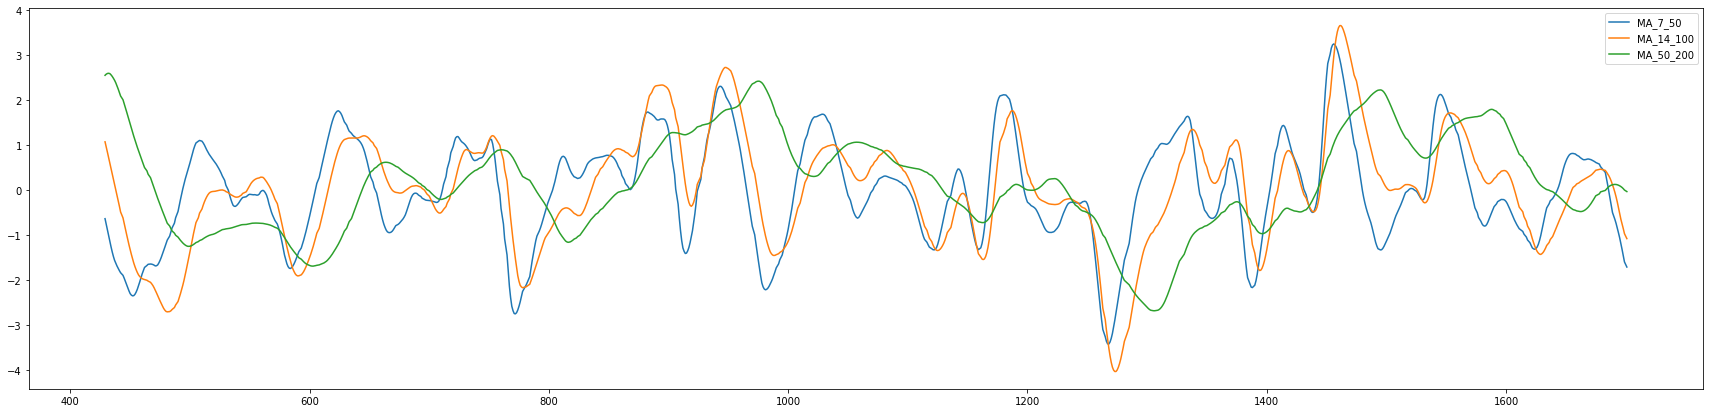

In [2664]:
final_frame.iloc[:,:][["MA_7_50","MA_14_100","MA_50_200"]].plot(figsize=(30,7))

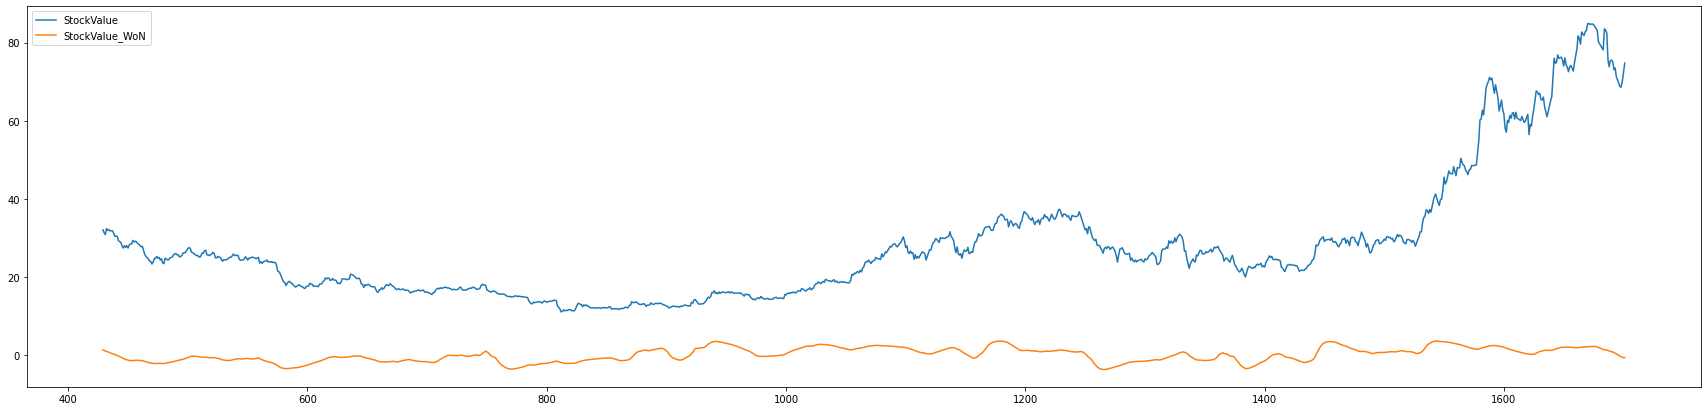

In [2665]:
final_frame.iloc[:,:][["StockValue", "StockValue_WoN"]].plot(figsize=(30,7))

In [2685]:
final_frame.iloc[456:478,:]

,StockValue_WoN,Date,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,MA_50_200_CH,StockValue,rec_1,rec_2
933,2.28285,2017-01-13,1.955376,1.080838,0.737981,-0.092264,-0.735300,1.217396,1.173102,1.473281,0.008314,13.90,BUY,SELL
934,2.59921,2017-01-16,2.078240,1.302336,0.769149,-0.045732,-0.715245,1.309091,1.348068,1.484394,0.009024,14.40,BUY,BUY
935,2.88566,2017-01-17,2.232383,1.532198,0.804564,0.003290,-0.694718,1.427820,1.528908,1.499282,0.009797,14.87,BUY,BUY
936,3.05911,2017-01-18,2.406247,1.760104,0.842251,0.053632,-0.674307,1.563995,1.706472,1.516558,0.010562,14.67,BUY,BUY
937,3.21933,2017-01-19,2.589029,1.991489,0.880728,0.103231,-0.653928,1.708301,1.888259,1.534656,0.011215,15.07,BUY,BUY
938,3.36905,2017-01-20,2.786711,2.198323,0.921459,0.153094,-0.634547,1.865252,2.045230,1.556007,0.011685,16.05,BUY,BUY
939,3.46036,2017-01-23,2.982224,2.395189,0.965459,0.202931,-0.615579,2.016765,2.192258,1.581038,0.012090,16.00,BUY,BUY
940,3.54124,2017-01-24,3.161995,2.558685,1.011703,0.252658,-0.597508,2.150291,2.306028,1.609211,0.012487,16.51,BUY,BUY
941,3.54925,2017-01-25,3.297715,2.687978,1.059013,0.301989,-0.579739,2.238702,2.385989,1.638752,0.012843,15.85,BUY,BUY
942,3.53708,2017-01-26,3.390775,2.811579,1.103455,0.350397,-0.562095,2.287320,2.461183,1.665550,0.013053,16.03,BUY,BUY


In [2667]:
get_locations(final_frame)

[[52,
  77,
  125,
  134,
  148,
  172,
  198,
  206,
  268,
  300,
  335,
  365,
  395,
  398,
  399,
  431,
  456,
  478,
  526,
  559,
  669,
  677,
  685,
  698,
  772,
  806,
  877,
  889,
  922,
  950,
  1010,
  1033,
  1103,
  1131,
  1137,
  1140],
 [66,
  77,
  125,
  139,
  155,
  172,
  198,
  215,
  267,
  304,
  341,
  365,
  394,
  437,
  457,
  484,
  533,
  562,
  588,
  608,
  657,
  659,
  675,
  677,
  685,
  705,
  781,
  806,
  866,
  868,
  884,
  889,
  924,
  959,
  1017,
  1039,
  1111,
  1131,
  1136,
  1144]]

In [2668]:
first_transactions = get_transactions(final_frame, "rec_1", get_locations(final_frame)[0])
first_transactions

[[52, 77],
 [125, 134],
 [148, 172],
 [198, 206],
 [268, 300],
 [335, 365],
 [395, 398],
 [399, 431],
 [456, 478],
 [526, 559],
 [669, 677],
 [685, 698],
 [772, 806],
 [877, 889],
 [922, 950],
 [1010, 1033],
 [1103, 1131],
 [1137, 1140]]

In [2669]:
second_transactions = get_transactions(final_frame, "rec_2", get_locations(final_frame)[1])
second_transactions

[[66, 77],
 [125, 139],
 [155, 172],
 [198, 215],
 [267, 304],
 [341, 365],
 [394, 437],
 [457, 484],
 [533, 562],
 [588, 608],
 [657, 659],
 [675, 677],
 [685, 705],
 [781, 806],
 [866, 868],
 [884, 889],
 [924, 959],
 [1017, 1039],
 [1111, 1131],
 [1136, 1144]]

In [2670]:
first_returns = returns(final_frame, first_transactions)
first_returns

[0.04819277108433746,
 -0.11475409836065563,
 0.13467048710601728,
 -0.059067357512953396,
 -0.024955436720142495,
 -0.0967976710334789,
 -0.015372168284789604,
 -0.056074766355140235,
 0.14388489208633093,
 0.1744040150564617,
 0.005037783375314866,
 -0.013801035077630936,
 0.0007363770250368031,
 0.03993203058623625,
 0.06785714285714281,
 0.2978378378378379,
 0.13319946452476578,
 -0.01317365269461071]

In [2671]:
second_returns = returns(final_frame, second_transactions)
second_returns

[-0.0526315789473684,
 -0.2295081967213114,
 0.1578947368421052,
 -0.10362694300518134,
 -0.07573964497041417,
 -0.10975609756097557,
 0.03916666666666672,
 0.10624999999999996,
 0.13127646702964296,
 0.22374798061389334,
 -0.05865314989138309,
 -0.008695652173913078,
 0.012650948821161521,
 0.12221304706853844,
 0.11277445109780447,
 -0.03773584905660381,
 0.04907975460122704,
 0.17450315075133307,
 0.11235216819973734,
 -0.0332906530089628]

In [2672]:
first_cum_return = prod(first_returns)
second_cum_return  = prod(second_returns)

In [2673]:
first_cum_return

1.7414247258978162

In [2674]:
second_cum_return

1.4925933631217005

In [2675]:
def stop_loss(return_list, threshold):
    return_list = np.array(return_list)
    return_list[return_list < -threshold] = -threshold
    return_list = list(return_list)
    return prod(return_list)

In [2686]:
stop_loss(first_returns, 0.02)

2.273345870901777

In [2687]:
stop_loss(second_returns, 0.02)

2.69358794598052

In [2678]:
sum([t[1]-t[0] for t in first_transactions])

367

In [2679]:
sum([t[1]-t[0] for t in second_transactions])

380

In [2680]:
final_frame.shape[0]

1154